# 工作区NS仿真

In [1]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as ani

dt=1#步长
Cn=0#换道次数
Ch=[]#换道信息记录
l=6#标准车长，同时也是元胞长度，卡车长度为其两倍
v_max=5#标准车辆最大速度
pm=1/3#慢化概率

In [2]:
class Cell:#元胞定义
    def __init__(self,ID=0,LID=1,CL=6,T=10,S=999999,V=0,X=0,flag=0,stop=0,p=0.1):
        self.ID=ID#元胞ID
        self.l=CL#元胞长度
        self.LID=[LID for t in range(T)]#元胞所在车道ID
        self.FID=-1#跟驰前车ID
        self.BID=-1#被跟驰后车ID
        self.FCID=-1#换道后 前车ID
        self.BCID=-1#换道后 后车ID
        self.FFlag=0#跟驰检测
        self.CFlag=-1#换道检测
        self.s=[S for t in range(T)]#车头间距数据储存
        self.cs=[S for t in range(T)]#换道车头间距数据储存
        self.cbs=[S for t in range(T)]#换道后车车头间距数据储存
        self.v=[V for t in range(T)]#速度数据储存
        self.x=[X for t in range(T)]#位移数据储存
        self.flag=flag#是否在路段内
        self.stop=stop#是否停止
        self.p=p#驾驶激进程度

In [3]:
class Lane:#车道定义
    def __init__(self,ID=0,LL=1000,Circle=0,T=3600,Iq=1000/3600,flag=1):
        self.flag=flag#末端能否通行
        self.ID=ID#车道ID
        self.L=LL#车道长度
        self.Iq=Iq#输入流量
        if Circle==1:#周期边界
            self.CID=0#车道下次到达的车辆的ID
            self.Cells=[Cell(n,ID,CL=RDMH()*l,T=T,V=0,X=n*s) for n in range(int(LL/s))]
        else:#开放边界
            self.CID=0
            self.Cells=[Cell(n,ID,CL=l,T=T,V=5,X=-l) for n in range(int(T*Iq))]

In [4]:
class Space:#元胞空间定义
    def __init__(self,SL=1000,ln=1,Circle=0,T=3600,Iq=1000/3600,DT=0):
        self.L=SL#元胞空间总长
        if Circle==1:#设置边界条件
            self.Lanes=[Lane(l,SL,Circle,T=T,Iq=Iq) for l in range(ln)]
        else:#开放边界
            self.Lanes=[Lane(l,SL,T=T,Iq=Iq) for l in range(ln)]
        if DT!=0:#设置路段检测器
            self.DT=[Detector(n*SL/DT) for n in range(DT)]

In [5]:
class Detector:#检测器定义
    def __init__(self,X=0):
        self.x=X#检测器位置
        self.v=0#平均速度
        self.q=0#平均流量

In [6]:
def RDM():#随机慢化概率
    u=random.uniform(0,1)
    if u<pm:
        return 1
    else:
        return 0

In [7]:
def RDMH():#卡车概率
    h=random.uniform(0,1)
    if h<ph:
        return 2
    else:
        return 1

In [8]:
def RDMC(p=0.1):#换道概率
    c=random.uniform(0,1)
    if c<p:
        return 1
    else:
        return 0

In [9]:
def NS(C,t):#NS模型原本
    #加速
    C.v[t+1]=min(C.v[t]+1,v_max)
    #减速
    C.v[t+1]=min(C.v[t+1],int(C.s[t]/l))
    #随机慢化
    if RDM():
        C.v[t+1]=max(C.v[t+1]-1,0)
    #位置更新
    C.x[t+1]=C.x[t]+C.v[t+1]*l

In [10]:
def NSC(V0=0,V3=0,G1=125,G2=float("inf"),G3=float("inf"),p=0.1):#换道概率
    if RDMC(p):
        if G1<G2 and V0>G1 and V3<G3:
            return 1
        else:
            return 0
    else:
        return 0

In [11]:
def Poisson(lam):#泊松近似，当步长足够小时与泊松无明显区别
    a=random.uniform(0,1)
    p=2.718281828459045**(-lam)
    f=p
    if a<f:
        return 0
    else:
        return 1

In [12]:
def Simulation(L=1000,ln=1,Circle=0,T=3600,Iq=1000/3600,DT=0):#仿真+可视化
    global Cn
    global Ch
    #初始化
    T=int(T/dt)
    SPC=Space(L,ln,Circle,T,Iq,DT)
    #路段内的车
    Cells=[]
    #工作区超大静止元胞
    STOP=Cell(ID=0,LID=2,CL=80,T=T,S=float("inf"),V=0,X=4*1000+80+1,flag=0,stop=1,p=0)
    #仿真
    for t in range(T-1):
        
        #到达
        for LN in SPC.Lanes:
            if Poisson(LN.Iq*dt):
                if LN.CID<T*LN.Iq*dt:
                    C=LN.Cells[LN.CID]
                    C.flag=1
                    Cells.append(C)
                    LN.CID+=1
        if t==0.25*60*60:
            Cells.insert(0,STOP)
        
        #跟驰判断与匹配
        for C in Cells:
            if C.stop==0:
                C.FFlag=0
                for F in Cells:
                    if F.LID[t]==C.LID[t] and F.x[t]-F.l>C.x[t]:
                        C.FFlag=1
                        if F.x[t]-F.l-C.x[t]<C.s[t]:
                            C.FID=Cells.index(F)
                            C.s[t]=F.x[t]-F.l-C.x[t]
                if C.FFlag==0:
                    C.FID=-1
        
        
        #跟驰
        for C in Cells:
            if C.stop==0:
                NS(C,t)
        
        #后车查询
        for C in Cells:
            if C.stop==0:
                for B in Cells:
                    if B.FID==Cells.index(C):
                        C.BID=Cells.index(B)
                        break
                C.BID=-1
        
        #相邻车道前车判断与匹配
        for C in Cells:
            if C.stop==0:
                C.FCID=-1
                tid2=-1
                ts2=float("inf")
                tid0=-1
                ts0=float("inf")
                for F in Cells:
                    if ((F.LID[t]==1 and C.LID[t]==2) or (F.LID[t]==1 and C.LID[t]==0)) and -l<=F.x[t]-F.l-C.x[t]<C.cs[t]:
                        C.FCID=Cells.index(F)
                        C.cs[t]=F.x[t]-F.l-C.x[t]
                        continue
                    if (F.LID[t]==2 and C.LID[t]==1) and -l<=F.x[t]-F.l-C.x[t]<ts2:
                        tid2=Cells.index(F)
                        ts2=F.x[t]-F.l-C.x[t]
                        continue
                    if (F.LID[t]==0 and C.LID[t]==1) and -l<=F.x[t]-F.l-C.x[t]<ts0:
                        tid0=Cells.index(F)
                        ts0=F.x[t]-F.l-C.x[t]
                        continue
                if ts0>=ts2:#对于中间车道，拥有更多换道后前进空间的作为换道目标
                    C.FCID=tid0
                    C.cs[t]=ts0
                else:
                    C.FCID=tid2
                    C.cs[t]=ts2
        
        #相邻车道后车判断与匹配
        for C in Cells:
            if C.stop==0:
                C.BCID=-1
                for B in Cells:
                    if ((B.LID[t]==1 and C.LID[t]==2) or (B.LID[t]==1 and C.LID[t]==0) or (B.LID[t]==Cells[C.FCID].LID and C.LID[t]==1)) and 0<C.x[t]-B.x[t]<C.cbs[t]:
                        C.BCID=Cells.index(B)
                        C.cbs[t]=C.x[t]-B.x[t]
        
        #换道判断
        for C in Cells:
            if C.stop==0 and 0<C.x[t]<L:
                V0=C.v[t];V3=0;G1=6;G2=float("inf");G3=float("inf");p=C.p
                if C.BCID!=-1:
                    V3=Cells[C.BCID].v[t]
                if C.FID!=-1:
                    G1=C.s[t]/l
                if C.FCID!=-1:
                    G2=C.cs[t]/l
                if C.BCID!=-1:
                    G3=C.cbs[t]/l

                if 0.25*60*60<t<0.75*60*60 and C.LID[t]==2:#前30m换道概率逐渐上升
                    if 4000-30<=C.x[t]<=4000:
                        p=(30-(4000-C.x[t]))/30+0.1
                if 0.25*60*60<t<0.75*60*60 and C.LID[t]==1 and C.FCID==2:#后30m换道概率逐渐下降
                    if 4080<=C.x[t]<=4080+30:
                        p=1-(30-(4110-C.x[t]))/30+0.1
                
                if NSC(V0,V3,G1,G2,G3,p):
                    if C.LID[t]==0 or C.LID[t]==2:
                        C.CFlag=1
                    else:
                        C.CFlag=Cells[C.FCID].LID[t]
                else:
                    C.CFlag=-1
        
        #换道
        for C in Cells:
            if C.stop==0:
                if C.CFlag!=-1:
                    if C.CFlag==2 and 0.25*60*60<=t<=0.75*60*60 and 4000<=C.x[t+1]<=4080:
                        pass
                    else:
                        if t>300/dt:#5min预热
                            Cn+=1
                            Ch.append((C.x[t],C.LID[t]))
                        for tt in range(t,T-1):#换道成功后，修改该车所在车道
                            C.LID[tt]=C.CFlag
        
        #出界处理
        for C in Cells:
            if C.x[t]>L:#将位移大于路段长度的车辆从路段中剔除
                C.flag=0
                del Cells[Cells.index(C)]
        
        #工作区移除
        if t==0.75*60*60:
            del Cells[Cells.index(STOP)]
        
        
    print("ok")
    return SPC.Lanes

In [13]:
def Visual(Results,ll,ln,T):#可视化
    x=[100*int(i/ln) for i in range(int(ln*ll/100+ln))]
    y=[i%ln for i in range(int(ln*ll/100+ln))]
    #print(y)
    s=[0 for i in range(int(ln*ll/100+ln))]
    for ch in Ch:
        if 0<=ch[0]<=ll:
            s[ln*int(ch[0]/100)+ch[1]]+=1
    plt.rcParams["font.family"] = 'Arial Unicode MS'
    plt.figure(figsize=(15,1))
    plt.title("换道频率分布")
    plt.xlim([0,ll])
    plt.scatter(x,y,s)
    
    C=[]
    for i in range(ln):
        C.extend(Results[i].Cells)
    for i in range(ln):
        plt.figure(figsize=(20,10))
        plt.title("第"+str(i+1)+"条车道时空分布图")
        for t in range(int(T/dt)-1):
            x=[]
            for c in C:
                if c.LID[t]==i:
                    x.append(c.x[t])
            y=[t for tT in range(len(x))]
            plt.scatter(x,y,1,c='k')
        plt.show()

In [14]:
L=6*1000
ln=3
Circle=0
T=1*60*60
Iq=1500/3600
DT=0
Results=Simulation(L,ln,Circle,T,Iq)

ok


In [15]:
print(Cn/dt,Cn/T)

2261.0 0.6280555555555556


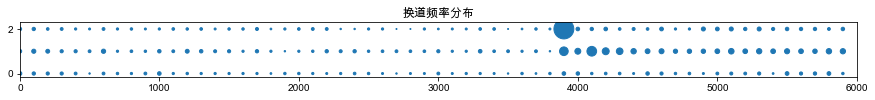

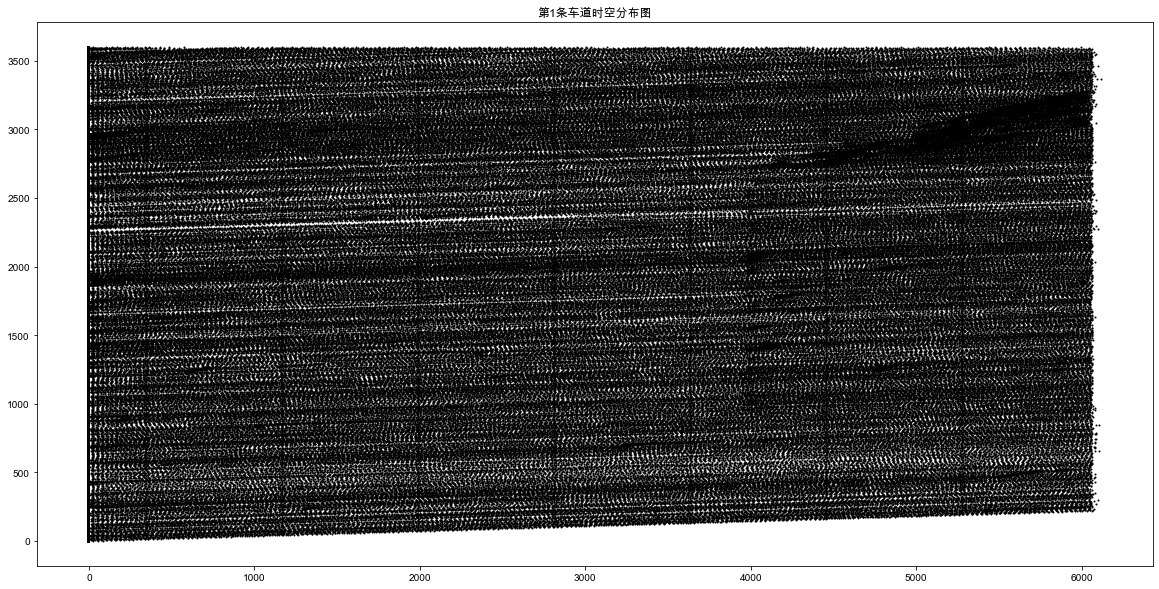

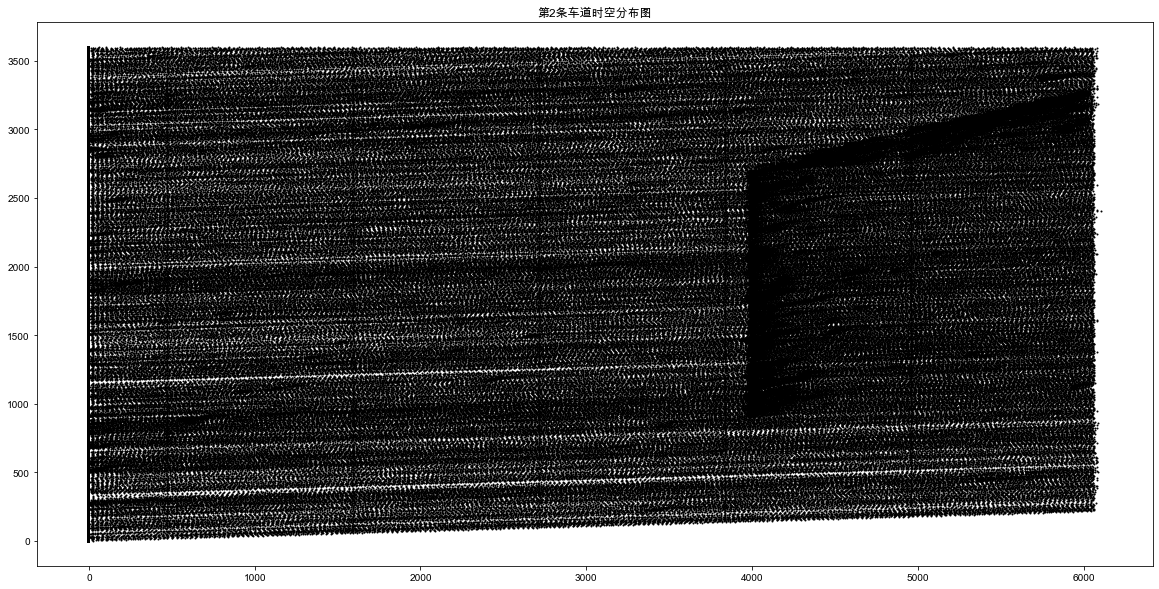

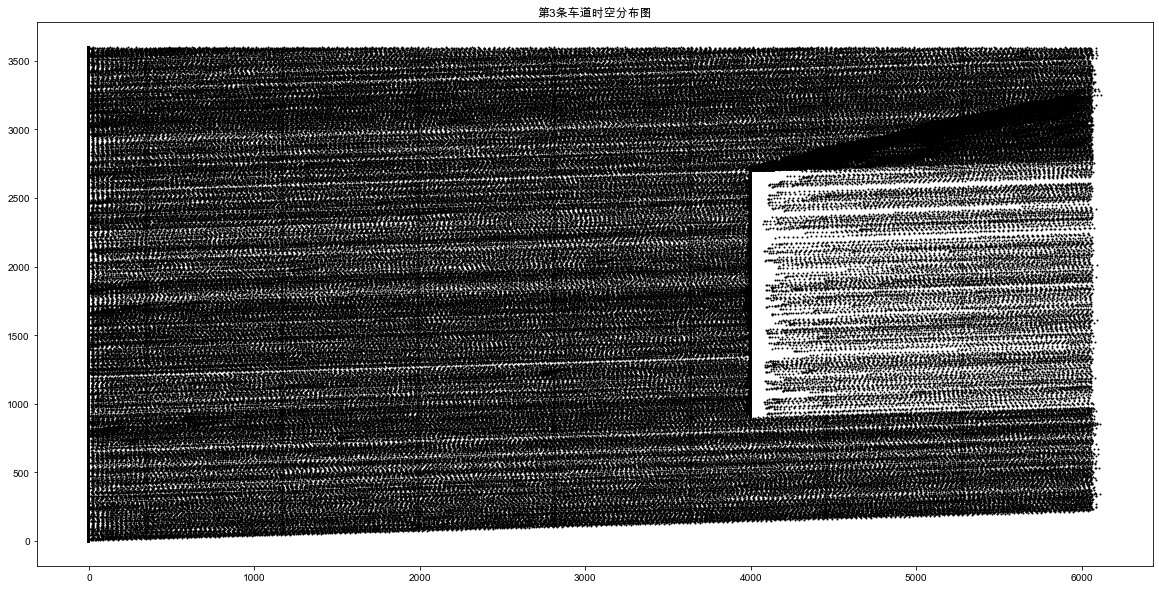

In [16]:
Visual(Results,L,ln,T)

> Sofarja@outlook.com
>
> ---
>
> 21018116
>
> 郭艺铧
>
> 交通工程